# TP noté - cours de Deep Learning ZZ3

Auteurs : *Paul Maitre* & *Enzo Magal*

Ce notebook sert à entraîner notre modèle et à l'enregistrer. Il présente également notre démarche sans montrer les différentes itérations pour chaques étapes. Il a été développé sur Kaggle et les modèles ont été entraînés à l'aide du GPU P100 disponible sur la plateforme.

# Librairies

In [1]:
!pip install visualkeras
!pip install --upgrade cleanlab
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
import random

# Dealing with files
import pickle

# Display 
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras 
from collections import defaultdict

# Tune hyperparameters
import keras_tuner

# Get current time
from datetime import datetime

# Dealing with images
from PIL import Image

# Scikit-learn 
from sklearn.metrics import confusion_matrix

# Cleaning the dataset with Cleanlab
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues

# Tensorflow & Keras
import tensorflow as tf
import tensorflow.keras as tk
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input,\
                                    Dense,\
                                    Activation,\
                                    Lambda,\
                                    Flatten,\
                                    Dropout,\
                                    Conv2D,\
                                    MaxPooling2D,\
                                    InputLayer,\
                                    ReLU,\
                                    LeakyReLU,\
                                    ZeroPadding2D,\
                                    GlobalAveragePooling2D,\
                                    GlobalMaxPooling2D,\
                                    BatchNormalization,\
                                    GRU,\
                                    LSTM,\
                                    Reshape,\
                                    TimeDistributed,\
                                    SpatialDropout2D

from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,\
                                       ReduceLROnPlateau,\
                                       ModelCheckpoint

from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16

# Load Data

In [4]:
# !unzip "/content/drive/MyDrive/TP noté/Data_Train_Valid.zip"

In [3]:
def get_data(size_t=None, frac_t=None):
    """
        size_t = size of the test set for each class, default=None, contrainte: <5000
        frac_t = fraction of the validation data used for test set for each class, default=None, contrainte: < 1.0
    """

    ###### Training set
    train_df = pd.read_csv('/kaggle/input/challenge-img-classification/train.csv')
    
    ###### Validation and test sets 
    valid_test_df = pd.read_csv('/kaggle/input/challenge-img-classification/valid.csv')
    
    ###### Separation between validation and test sets
    if not(size_t==None and frac_t==None): # If we want a test set
        if not(size_t==None):
            # Extraction of size_t element from valid_test_df for each class into our test set
            zero_df = valid_test_df[:5000].sample(n=size_t) 
            un_df = valid_test_df[5000:10000].sample(n=size_t)
            deux_df = valid_test_df[10000:15000].sample(n=size_t)
            trois_df = valid_test_df[15000:20000].sample(n=size_t)
            quatre_df = valid_test_df[20000:25000].sample(n=size_t)
        else:
            # Extraction of a fraction frac_t of elements from valid_test_df for each class into our test set
            zero_df = valid_test_df[:5000].sample(frac=frac_t)
            un_df = valid_test_df[5000:10000].sample(frac=frac_t)
            deux_df = valid_test_df[10000:15000].sample(frac=frac_t)
            trois_df = valid_test_df[15000:20000].sample(frac=frac_t)
            quatre_df = valid_test_df[20000:25000].sample(frac=frac_t)
            
        ### Concatenation into the test set for each extracted dataframe (corresponding to a class test data)
        test_df = pd.concat(objs=[zero_df, un_df, deux_df, trois_df, quatre_df], axis=0, ignore_index=False)
        ### Extract what is left behind: the validation set
        test_index = test_df.index
        valid_df = valid_test_df.drop(index=test_index).sample(frac=1)
        # valid_df = valid_test_df.loc[~valid_test_df.index.isin(test_index)] # Même résultat
        ### Reset indexes
        test_df = test_df.reset_index(drop=True)
        valid_df = valid_df.reset_index(drop=True)
        ### Output
        res = (train_df, valid_df, test_df)
        
    else: # No test set
        res = (train_df, valid_test_df,)
        
    ###### Shapes
    print(f"Shape train set dataframe = {res[0].shape}")
    print(f"Shape valid set dataframe = {res[1].shape}")
    try:
        print(f"Shape test set dataframe  = {res[2].shape}")
    except:
        print("No test set.")
        pass

    return res

In [4]:
train_df, valid_df, test_df = get_data(size_t=None, frac_t=0.5)

Shape train set dataframe = (75000, 3)
Shape valid set dataframe = (12500, 3)
Shape test set dataframe  = (12500, 3)


In [5]:
def create_XY(train_df, valid_df, test_df=None, nb_classes=5):
    """
    Function : Get images data and separate them into X (data) | Y (labels)
    
    Inputs   : 2 <pandas Dataframe> : - training data
                                      - validation data
    
    Outputs  : 4 <numpy array> : - x_train
                                 - x_valid
                                 - y_train
                                 - y_valid
                               
    """
    # Training data 
    x_train = []
    for i in range(len(train_df)):
        try:
            train_path = '/kaggle/input/challenge-img-classification/images/'+train_df.loc[i, 'relative_path']
            image = Image.open(train_path)
            images_arr = np.asarray(image)
            x_train.append(images_arr)
        except:
            print("ERREUR : Fichier train PNG non trouvé.")
            break
    x_train = np.array(x_train).reshape(-1, 28, 28, 1)
    # Validation data
    x_valid = []
    for i in range(len(valid_df)):
        try:
            valid_path = '/kaggle/input/challenge-img-classification/images/' + valid_df.loc[i, 'relative_path']
            image = Image.open(valid_path)
            images_arr = np.asarray(image)
            x_valid.append(images_arr)
        except:
            print("ERREUR : Fichier valid PNG non trouvé.")
            break
    x_valid = np.array(x_valid).reshape(-1, 28, 28, 1)
    # Training and validation targets
    y_train = train_df['class_label'].to_numpy()
    y_valid = valid_df['class_label'].to_numpy()
    y_train = tk.utils.to_categorical(y_train, nb_classes)
    y_valid = tk.utils.to_categorical(y_valid, nb_classes)
    # Display shapes 
    print("Shape x_train : ", x_train.shape)
    print("Shape y_train : ", y_train.shape)
    print("\nShape x_valid : ", x_valid.shape)
    print("Shape y_valid : ", y_valid.shape)
    res = [x_train, y_train, x_valid, y_valid]
    
    # Test data
    try:
        x_test = []
        for i in range(len(test_df)):
            try:
                test_path = '/kaggle/input/challenge-img-classification/images/' + test_df.loc[i, 'relative_path']
                image = Image.open(test_path)
                images_arr = np.asarray(image)
                x_test.append(images_arr)
            except:
                print("ERREUR : Fichier test PNG non trouvé.")
                break
        x_test = np.array(x_test).reshape(-1, 28, 28, 1)
        # Training and validation targets
        y_test = test_df['class_label'].to_numpy()
        y_test = tk.utils.to_categorical(y_test, nb_classes)
        # Display shapes
        print("\nShape x_test : ", x_test.shape)
        print("Shape y_test : ", y_test.shape)
        # Return it also
        res.append(x_test)
        res.append(y_test)
    except:
        print("\nNo test set.")
        pass
        
    return res

In [6]:
try:
    print(f"data shape:\n{x_train.shape}\n{x_valid.shape}\n{x_test.shape}\n")
except:
    print("Création en cours des inputs...\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test = create_XY(train_df, valid_df, test_df)
    print("\nInputs OK.\n")

Création en cours des inputs...

Shape x_train :  (75000, 28, 28, 1)
Shape y_train :  (75000, 5)

Shape x_valid :  (12500, 28, 28, 1)
Shape y_valid :  (12500, 5)

Shape x_test :  (12500, 28, 28, 1)
Shape y_test :  (12500, 5)

Inputs OK.



# Fouille de données

### Dataframes informations

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     75000 non-null  object
 1   relative_path  75000 non-null  object
 2   class_label    75000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [8]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     12500 non-null  object
 1   relative_path  12500 non-null  object
 2   class_label    12500 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 293.1+ KB


### Visualization

In [9]:
nb_classes=5
classes = ["basket","eye","binoculars","rabbit","hand"]

In [207]:
def plot_images(x, y, idx):
    """
    Affiche les images correspondantes aux indices (idx) d'un dataframe d'images (df)
    """
    plt.figure(figsize=(18,9))
    nb_images = len(idx)
    nb_rows = int((nb_images / 5))
    if (nb_images % 5 != 0):
        nb_rows += 1

    for i in range(len(idx)):
        ax = plt.subplot(nb_rows, 5, i+1)
        array = np.reshape(x[idx[i]], (28, 28))
        im = Image.fromarray(array)
        fig=ax.imshow(im)
        plt.title(classes[np.argmax(y[idx[i]])])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

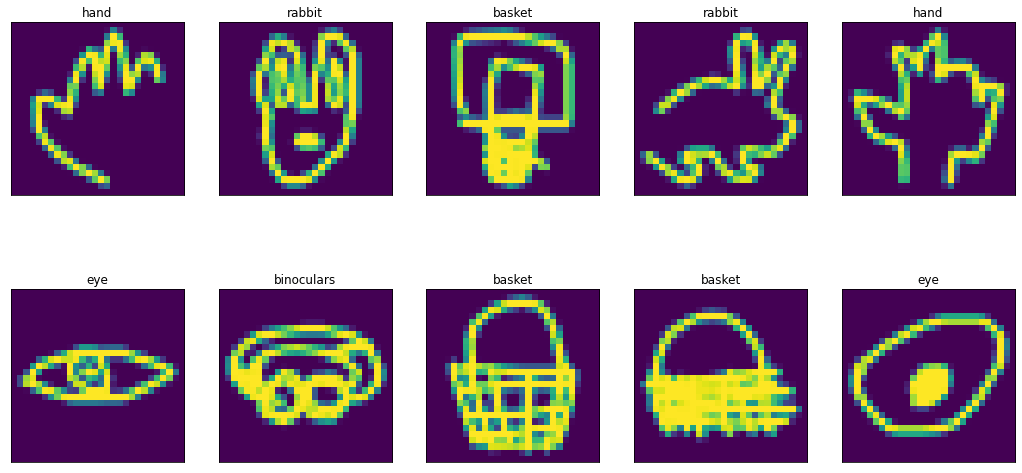

In [208]:
# Images d'entraînement aléatoirement choisies
indexes = random.sample(range(1,len(train_df)), 10)
plot_images(x=x_train, y=y_train, idx=indexes)

# Recherche du meilleur modèle

Dans cette partie nous recherchons l'architecture la plus performante pour répondre à notre problème. 

Le type de modèle le plus adéquat nous a parrut être le CNN étant donné que nous travaillons avec des images. Vous verrez donc dans les parties suivantes comment nous avons tenté d'optimiser ce type de modèle pour qu'il effectue la meilleur classification possible. 

## Fonctions et codes pour la création, la visualisation, l'entraînement et l'analyse des résultats de nos modèles

In [32]:
# Definition des couleurs pour la visualisation des modèles avec visual keras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'darkseagreen'
color_map[Dense]['fill'] = 'teal'
color_map[MaxPooling2D]['fill'] = 'mediumseagreen'
color_map[GlobalMaxPooling2D]['fill'] = 'purple'
color_map[BatchNormalization]['fill'] = 'cornFlowerBlue'
color_map[Dropout]['fill'] = 'skyblue'
color_map[Flatten]['fill'] = 'maroon'

In [37]:
def train_model(model, x_train, y_train, x_valid, y_valid, epochs=30, batch_size=128, learning_rate=0.01, datagen=None):
    """
    Entraîne le modèle passé (model) à l'aide des données d'entraînement et de validation, et selon les hyperparamètres d'entraînement choisis.
    
    Si datagen != None alors on fait de la data augmentation à l'aide du générateur datagen.
    """
    ############ Others training hyperparameters
    METRICS = ['accuracy']
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    # Early stopping if no improvement
    EARLY_STOP = EarlyStopping(monitor='val_loss', 
                               patience=7, 
                               mode='min',
                               baseline=None,
                               restore_best_weights=True,
                               verbose=1)
    # Reduce learning rate when a metric has stopped improving.
    LR_DECAY = ReduceLROnPlateau(monitor = 'val_loss', 
                                 factor = 0.5,
                                 patience = 2, 
                                 min_lr = 1e-15,
                                 mode = 'min', 
                                 verbose = 1)

    ############ Compilation code
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    ############ Display Shapes
    print(f"Training data   : {x_train.shape[0]}")
    print(f"Validation data : {x_valid.shape[0]}")

    ############ Train model
    if (datagen != None):
        print("*** Training with data augmentation. ***\n")
        hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                   validation_data = (x_valid, y_valid), 
                                   epochs = epochs,
                                   callbacks=[EARLY_STOP, LR_DECAY])
    else :
        print("*** Training without data augmentation. ***\n")
        hist = model.fit(x=x_train, y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EARLY_STOP, LR_DECAY])


    print(f"Training data   : {x_train.shape[0]}")
    print(f"Validation data : {x_valid.shape[0]}")

    return hist

In [49]:
def display_learning(history, epochs): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    val_range = min(epochs, len(loss)) 
    epochs_range = range(val_range)

    plt.figure(figsize=(8, 8))
    plt.tight_layout()

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss', color='green')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.legend(loc='upper right')
    plt.title('Categorical Cross Entropy Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()

## Modèle 1 : CNN

Nous avons commencé d'abord à tester une architecture basique d'un CNN avec 2 blocs de convolutions composées de plusieurs couches : 

*   convolution 2D
*   batch normalization 
*   activation
*   spatial dropout : on a trouvé en cherchant comment placé le dropout dans un CNN que la spatial dropout permettait vraiment une réduction de l'overfitting 
*   max pooling 2D 

Et enfin d'une couche dense de neurones et de la couche dense finale de predictions (activation softmax) composées de 5 neurones (5 classes).




In [39]:
def basic_CNN_model(summary=True):
    ##################################################################################### Definition of the model
    model = Sequential(name='Basic_CNN')
    
    ##################################################################################### Convolutionnal block 1
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SpatialDropout2D(rate=0.1))
#     model.add(Dropout(rate=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ##################################################################################### Convolutionnal block 2
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SpatialDropout2D(rate=0.4))
#     model.add(Dropout(rate=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ##################################################################################### Flatten
    model.add(Flatten())
    
    ##################################################################################### Dense bloc
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(rate = 0.6))
    
    ##################################################################################### Output layer : dense with 5 units
    model.add(Dense(units=5, activation=tf.keras.activations.softmax))
    
    ##################################################################################### Summary 
    if (summary):
        model.summary()
    
    return model

In [209]:
############ Model choice 
basic_CNN = basic_CNN_model(summary=True)

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_48 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu_48 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
spatial_dropout2d_40 (Spatia (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_49 (Batc (None, 14, 14, 64)        25

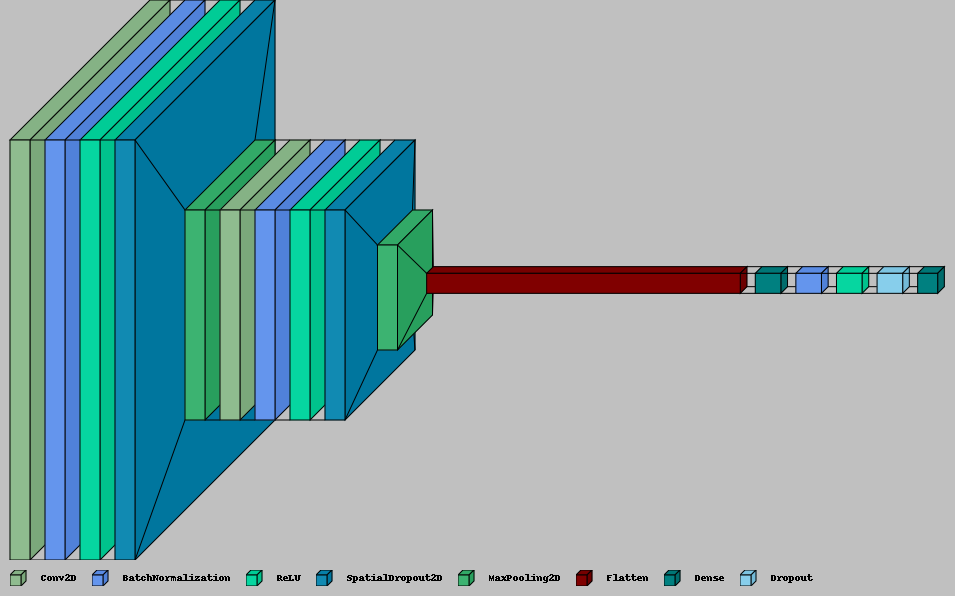

In [41]:
visualkeras.layered_view(basic_CNN, legend=True, color_map=color_map, scale_z = 0.1, scale_xy=15, spacing=15, background_fill='silver')


In [42]:
hist_basicCNN = train_model(basic_CNN, x_train, y_train, x_valid, y_valid, epochs=30, batch_size=128, learning_rate=0.001, datagen=None)

Training data   : 75000
Validation data : 12500
*** Training without data augmentation. ***



2023-01-31 17:27:20.461388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-31 17:27:22.285457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


586/586 [==============================] - 13s 9ms/step - loss: 0.4184 - accuracy: 0.8636 - val_loss: 0.2237 - val_accuracy: 0.9235
Epoch 2/30
586/586 [==============================] - 5s 8ms/step - loss: 0.2656 - accuracy: 0.9143 - val_loss: 0.1671 - val_accuracy: 0.9431
Epoch 3/30
586/586 [==============================] - 5s 8ms/step - loss: 0.2340 - accuracy: 0.9236 - val_loss: 0.1652 - val_accuracy: 0.9443
Epoch 4/30
586/586 [==============================] - 5s 8ms/step - loss: 0.2169 - accuracy: 0.9288 - val_loss: 0.1566 - val_accuracy: 0.9470
Epoch 5/30
586/586 [==============================] - 5s 8ms/step - loss: 0.2037 - accuracy: 0.9329 - val_loss: 0.1484 - val_accuracy: 0.9497
Epoch 6/30
586/586 [==============================] - 5s 9ms/step - loss: 0.1943 - accuracy: 0.9357 - val_loss: 0.1415 - val_accuracy: 0.9510
Epoch 7/30
586/586 [==============================] - 5s 8ms/step - loss: 0.1880 - accuracy: 0.9377 - val_loss: 0.1370 - val_accuracy: 0.9516
Epoch 8/30
586/5

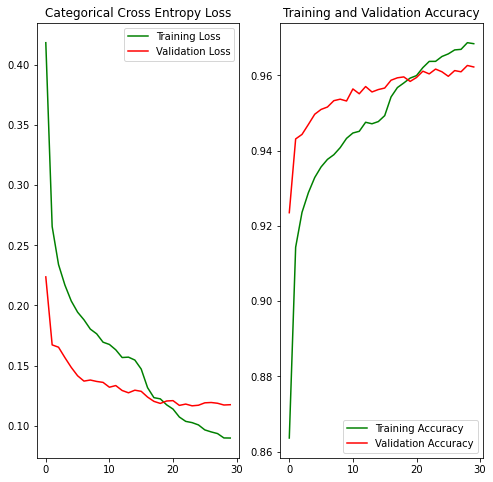

In [50]:
display_learning(hist_basicCNN, epochs=30)

In [52]:
# Test accuracy sur le dataset avec evaluate
print(f"Test set size : {x_test.shape[0]}\n")
basic_CNN.evaluate(x_test, y_test)

Test set size : 12500

391/391 [==============================] - 1s 3ms/step - loss: 0.1300 - accuracy: 0.9579


[0.13001123070716858, 0.9579200148582458]

In [54]:
# Enregistrement du modèle
basic_CNN.save('basic_CNN.h5')

Il s'agit d'un premier modèle et le résultat est déjà plutôt correct. Nous avons commencé par celui-ci car le CNN est le modèle classique pour traiter les problèmes de classification d'images comme nous l'avions vu en cours.

## Transfer Learning

Dans une seconde temps nous avons essayé de voir si l'on ne pouvait pas facilement faire mieux à l'aide d'un modèle pré-entrainé en faisant du transfer learning. Nous avons testé différents modèles disponibles via keras dont le ResNet50.


Lorsque l'on utilise les poids pré entrainés comme initialisation du ResNet avant de le réentrainé sur nos données, le modèles overfit. Lorsqu'au contraire l'on freeze toutes ses layers et que l'on n'apprend que sur les couches ajoutées à la fin, le modèle underfit. Nous avons donc essayé de geler seulement les *f* dernières layers du resnet afin d'obtenir un meilleur compromis des deux premiers essais sans succès. 

Un exemple de nos problèmes rencontrés avec le transfer learning : 


In [77]:
def transferLearning1_model(summary=False):
    """
    Pretrained ResNet50 : retraining pretrained model - used as initialisation for weights
    """
    
    ################################################################################################# Hyperparameters
    DROPOUT = 0.5
    
    
    ################################################################################################# Architecture
    model = Sequential(name='Transfer_Learning_fully_retrained')
    
    # conv2D with 3 filters to match input size of ResNet50 (rgb image)
    model.add(ZeroPadding2D(input_shape=(28, 28, 1), padding=(2, 2), name="reshape_padding"))
    model.add(Conv2D(filters=3, kernel_size=(1,1), input_shape=(32, 32, 1), name='reshaping_CONV2D'))
    
    model.add(LeakyReLU(alpha=0.1))
    
    # transfer learning using ResNet50 retrained
    pretrained_model = ResNet50(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
    # pretrained_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
    # pretrained_model =VGG16 (include_top = False, weights = 'imagenet', input_shape=(32, 32, 3))
    # pretrained_model.trainable = True

    # ResNet50
    model.add(pretrained_model)
    
    # Average Pooling 2D 
    model.add(GlobalAveragePooling2D(name='GlobalAvgPooling'))
    
    # Flatten
    model.add(Flatten())
    
    # Dense layer 
    model.add(Dense(units=128))
    
    # Dropout regularization 
    model.add(Dropout(rate=DROPOUT, name='Dropout'))
    
    # 5 outputs 
    model.add(Dense(5, activation=tk.activations.softmax, name='Dense_Output'))

    model.build()
    if (summary):
        model.summary()
      
    return model

In [78]:
resnet = transferLearning_model(summary=True)

Model: "Transfer_Learning_fully_retrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_padding (ZeroPadding (None, 32, 32, 1)         0         
_________________________________________________________________
reshaping_CONV2D (Conv2D)    (None, 32, 32, 3)         6         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
GlobalAvgPooling (GlobalAver (None, 2048)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
Dense_Output (Dense)         (Non

In [59]:
# for layer in resnet.layers:
#     print(f"{layer} : {layer.trainable}")

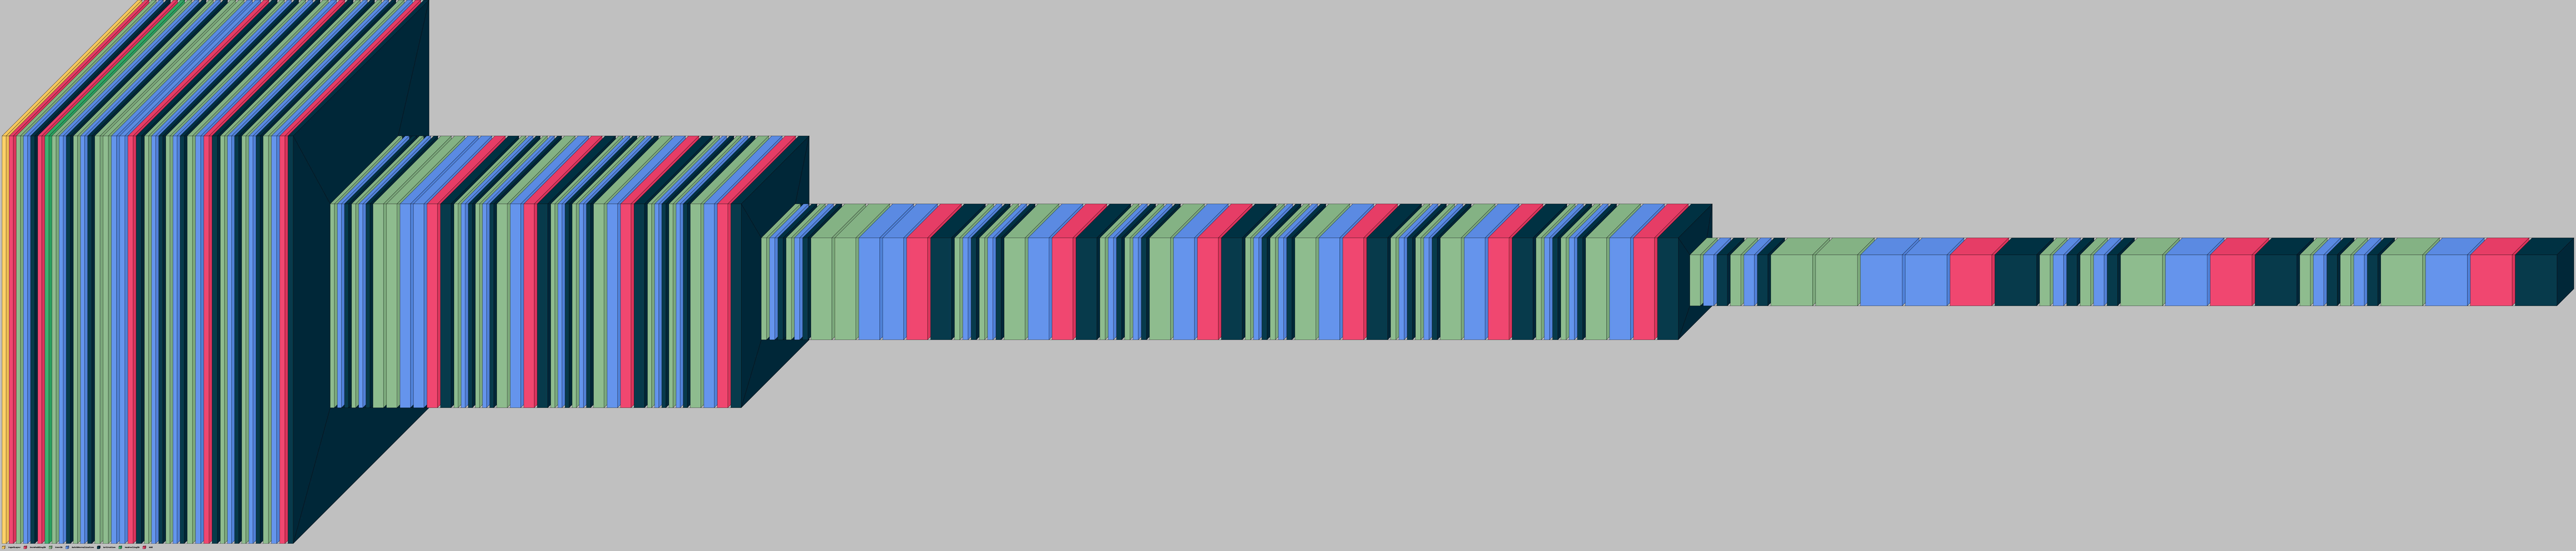

In [72]:
visualkeras.layered_view(ResNet50(input_shape=(32, 32, 3), include_top=False, weights='imagenet'), legend=True, color_map=color_map, scale_z = 0.1, scale_xy=250, spacing=15, background_fill='silver')

In [79]:
hist_resnet = train_model(model=resnet, x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid, epochs=30, batch_size=128, learning_rate=0.001, datagen=None)

Training data   : 75000
Validation data : 12500
*** Training without data augmentation. ***

Epoch 1/30
586/586 [==============================] - 48s 73ms/step - loss: 0.2480 - accuracy: 0.9229 - val_loss: 0.3866 - val_accuracy: 0.9293
Epoch 2/30
586/586 [==============================] - 41s 70ms/step - loss: 0.2122 - accuracy: 0.9337 - val_loss: 0.1733 - val_accuracy: 0.9406
Epoch 3/30
586/586 [==============================] - 41s 70ms/step - loss: 0.1366 - accuracy: 0.9550 - val_loss: 0.1376 - val_accuracy: 0.9531
Epoch 4/30
586/586 [==============================] - 41s 70ms/step - loss: 0.1129 - accuracy: 0.9621 - val_loss: 0.1561 - val_accuracy: 0.9488
Epoch 5/30
586/586 [==============================] - 41s 70ms/step - loss: 0.1033 - accuracy: 0.9651 - val_loss: 0.1423 - val_accuracy: 0.9509

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
586/586 [==============================] - 41s 70ms/step - loss: 0.0666 - accuracy: 0.9769 - va

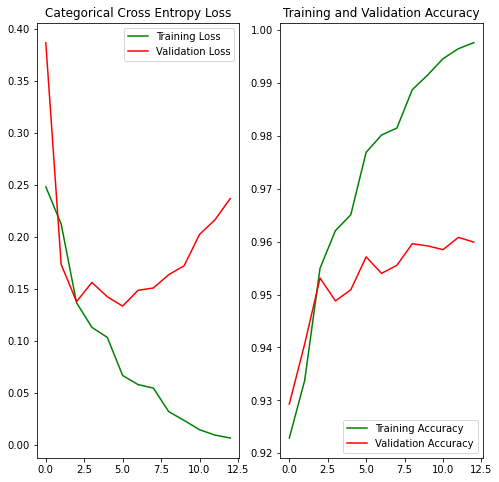

In [81]:
display_learning(hist_resnet, epochs=30)

Le modèle overfit au bout de seulement 3 epochs ! Même en testant différentes combinaisons en changeant le nombre de units ou le dropout nous n'arrivons pas à bien maîtriser l'entraînement du modèle.

In [83]:
# Test on test data
resnet.evaluate(x_test, y_test)

391/391 [==============================] - 7s 16ms/step - loss: 0.1422 - accuracy: 0.9552


[0.14219065010547638, 0.9552000164985657]

In [86]:
# Save the model
resnet.save("resnet.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Le résultat est inférieur à celui du CNN basique, sûrement car ce type d'architecture est beaucoup trop complexe pour notre problème. RESNET50 est développé pour faire de la classification d'images plus complexes et réparties en 1000 classes, ce qui revient en un problème bien plus compliqué.

Nous avons ainsi écarté cette option et préférés nous concentrer sur l'optimisation des hyperparamètres de notre CNN.

## Hyperparameters Search : CNN Architecture 

Nous avons ensuite commencé à chercher les meilleurs hyperparamètres pour notre modèle. 

Pour se faire nous avons créé deux fonctions :
- Une première *architecture_CNN* permet de créer un CNN avec les blocs et les paramètres choisis.
- Une deuxième *build_model* qui va permettre de changer les valeurs et de créer le CNN associé en appelant*architecture_CNN* à chaque essai.

A l'aide de ces fonctions nous avons créé et évalué les perfomances de 100 CNN différents afin de trouver les meilleurs hyperparamètres.

In [87]:
def architecture_CNN(blocs=[2, 2, 2], filters=[128, 256, 512], units=128, dropouts=[0.1, 0.2, 0.3, 0.4], activation='relu', max_pool=True, summary=True):
    """
    -> Architecture du modèle CNN.
    """
    
    # HPP
   
    ############################################################################################################## Definition of the model
    model = Sequential(name='HPP_CNN')
    
    ############################################################################################################## Convolutionnal block 1
    model.add(Conv2D(filters=filters[0], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    if (activation=='leakyrelu'):
        model.add(LeakyReLU())
    else: 
        model.add(ReLU())
    model.add(Dropout(rate=dropouts[0]))
    
    if (blocs[0]==2):
        model.add(Conv2D(filters=filters[0], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
        model.add(BatchNormalization())
        if (activation=='leakyrelu'):
            model.add(LeakyReLU())
        else: 
            model.add(ReLU())
        model.add(Dropout(rate=dropouts[0]))
    
    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Convolutionnal block 2
    model.add(Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    if (activation=='leakyrelu'):
        model.add(LeakyReLU())
    else: 
        model.add(ReLU())
    model.add(Dropout(rate=dropouts[1]))
    
    if (blocs[1]==2):
        model.add(Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
        model.add(BatchNormalization())
        if (activation=='leakyrelu'):
            model.add(LeakyReLU())
        else: 
            model.add(ReLU())
        model.add(Dropout(rate=dropouts[1]))

    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Convolutionnal block 3
    model.add(Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    if (activation=='leakyrelu'):
        model.add(LeakyReLU())
    else: 
        model.add(ReLU())
    model.add(Dropout(rate=dropouts[2]))
    
    if (blocs[2]==2):
        model.add(Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
        model.add(BatchNormalization())
        if (activation=='leakyrelu'):
            model.add(LeakyReLU())
        else: 
            model.add(ReLU())
        model.add(Dropout(rate=dropouts[2]))
    
    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Global Max Pooling 
    model.add(GlobalMaxPooling2D(keepdims=True))
    
    ############################################################################################################## Flatten
    model.add(Flatten())
    
    ############################################################################################################## Dense bloc
    model.add(Dense(units=units))
    model.add(BatchNormalization())
    if (activation=='leakyrelu'):
        model.add(LeakyReLU())
    else: 
        model.add(ReLU())
    model.add(Dropout(rate = dropouts[3]))
    
    ############################################################################################################## Output layer : dense with 5 units
    model.add(Dense(units=5, activation=tf.keras.activations.softmax))

    ############################################################################################################## Compile model
    model.compile(optimizer=OPTIMIZER,
                  loss=LOSS,
                  metrics=METRICS)
    
    ############################################################################################################## Summary 
    if (summary):
        model.summary()
    
    return model

In [88]:
def build_model(hp):
    """
    -> Recherche des meilleurs hyperparamétres du modèle.
    """
    
    ########## Filters numbers 
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    filters_3 = hp.Int('filters_3', min_value=128, max_value=512, step=128)
    filters_4 = hp.Int('filters_4', min_value=128, max_value=1024, step=128)
    filters = [filters_1, filters_2, filters_3, filters_4]
    
    ########## Size of blocks 
    bloc_1 = hp.Choice('bloc_1', [1, 2])
    bloc_2 = hp.Choice('bloc_2', [1, 2])
    bloc_3 = hp.Choice('bloc_3', [1, 2])
    bloc_4 = hp.Choice('bloc_3', [1, 2])
    blocs = [bloc_1, bloc_2, bloc_3, bloc_4]
    
    ########## Units numbers
    units = hp.Int('units', min_value=128, max_value=1024, step=128)
    
    ##########     Activation functions
    activation = hp.Choice('activation', ['relu','leakyrelu'])
    
    ########## Dropout rates
    dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)
    dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.6, step=0.1)
    dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.7, step=0.1)
    dropout4 = hp.Float('dropout4', min_value=0.1, max_value=0.8, step=0.1)
    dropout_dense = hp.Float('dropout_dense', min_value=0.2, max_value=0.8, step=0.1)
    dropouts = [dropout1, dropout2, dropout3, dropout_dense]
    
    ########## Call architecture with tuners
    model = architecture_CNN(blocs=blocs,
                             units=units,
                             dropouts=dropouts,
                             summary=False)
    return model

In [89]:
# build_model(keras_tuner.HyperParameters())

In [90]:
# %%time

# # Define Bayesian Search tuner
# tuner = keras_tuner.BayesianOptimization(hypermodel=build_model,
#                                          objective="val_accuracy",
#                                          max_trials=100,
#                                          executions_per_trial=1,
#                                          overwrite=True,
#                                          directory="hpp",
#                                          project_name="challenge-ISIMA")


# # Run the search
# tuner.search(x=x_train, y=y_train,
#              validation_data=(x_valid, y_valid),
#              epochs=EPOCHS,
#              batch_size=BATCH_SIZE,
#              callbacks=[EARLY_STOP])

In [91]:
# # Get the best models
# top = 3
# models = tuner.get_best_models(num_models=top)
# best_model = models[0]
# best_model.build(input_shape=(None, 28, 28))
# best_model.summary()

In [ ]:
# # Get top hyperparameters choices
# best_hparams = tuner.get_best_hyperparameters(num_trials=100)
# # Construct the dataframe to stock them
# hparams_list = [hparams.get_config() for hparams in best_hparams]
# result_bayesianOpt = pd.DataFrame(hparams_list)
# # also work : result_bayesianOpt = pd.DataFrame() seulement 
# for hparams in best_hparams:
#     hparams_dict = hparams.get_config()
#     result_bayesianOpt.append(hparams_dict, ignore_index=True)

In [ ]:
# result_bayesianOpt.to_csv("result_bayesianOpt.csv")

In [ ]:
# # explode dict into columns for each row/trial
# from pandas.io.json import json_normalize

# result_bayesianOpt_normalize = json_normalize(result_bayesianOpt['values'].apply(lambda x: x), errors='ignore')
# result_bayesianOpt_normalize.to_csv("result_bayesianOpt_normalize.csv")

In [ ]:
df_hp = pd.read_csv("/content/drive/MyDrive/Enzo_2023/ISIMA/Deep Learning/TP noté/bayesian_optimization/result_bayesianOpt_normalize.csv")

In [ ]:
df_hp.head()

,Unnamed: 0,filters_1,filters_2,filters_3,filters_4,bloc_1,bloc_2,bloc_3,bloc_4,units,activation,dropout1,dropout2,dropout3,dropout4,dropout_dense
0,0,128,256,512,128,2,2,2,1,256,relu,0.1,0.1,0.2,0.8,0.2
1,1,128,256,128,128,2,2,2,1,1024,relu,0.1,0.1,0.2,0.2,0.8
2,2,128,192,384,128,2,2,2,1,1024,relu,0.1,0.1,0.2,0.4,0.5
3,3,128,256,512,128,2,1,2,1,128,relu,0.1,0.1,0.2,0.8,0.2
4,4,128,64,512,128,2,2,2,1,128,relu,0.1,0.1,0.2,0.5,0.2


Les résultats de la recherche sont stockées dans le dataframe ci-dessus. Les architectures sont classées par ordre de performance décroissante.

Nous avons dans un premier temps déterminé qu'il fallait supprimer le 4ème bloc qui semble en trop. l'optimization bayesienne a eu tendance à minimiser les paramètres de ces couches : 1 seul bloc, 128 filtres, 0.8 de dropout rate. Toutes sont les valeurs minimales (maximale pour le dropout) appartenant à l'espace de recherche. 

Pour les autres hyperparamètres, nous avons décidé de nous inspiré du meilleur (96% de précision sur le set de validation mais qui overfittait) pour définir notre 'tuned_CNN' avec 3 blocs de 2 couches de convolution, le même nombre de filtres et des valeurs de dropout rate qui augmente au fil des blocs. Nous avons aussi regardé les histogrammes des hyperparamètres pour y trouver des tendances, vu que la recherche n'a pas pu être effectuée sur plus de 100 essais pour beaucoups d'hyperparamètres à optimiser (voir exemples suivant avec la taille de la couche dense et le nombre de filtres).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bba929340>]],
      dtype=object)

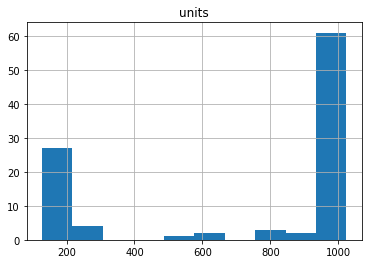

In [ ]:
df_hp.hist(column='units')

Nous avons opté pour un couche dense de 1024 neurones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bba268070>,
      dtype=object)

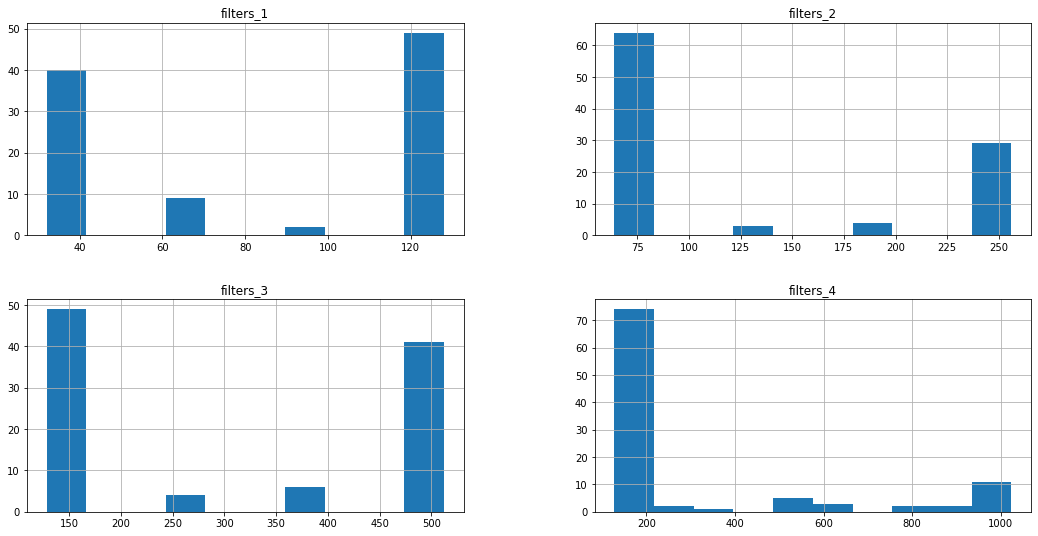

In [ ]:
df_hp.hist(column=['filters_1', 'filters_2', 'filters_3', 'filters_4'], figsize=(18, 9))

## Tuned model

Nous avons donc construit un premier modèle suivant les choix ci-dessus et nous avons opté pour cette architecture qui nous permet d'obtenir le meilleur score sur les sets de validation et de test. Ce modèle a tendance à overfit au bout d'un certain nombres d'epochs, et nous utilisons les méthodes de early stopping et de learning_rate_decay pour limiter ce phénomène. La fonction *tuned_CNN_model* est construite de sorte à pouvoir itérer dessus et reprend la structure de la fonction vu avant avec *architecture_CNN*. 

Les valeurs des hyperparamètres de l'architecture du CNN sont : 
* 3 blocs convolutif de taille 2 (la taille équivaut au nombres de couche de convolutions présentes)
* 128 filtres pour le bloc1, 256 pour le bloc2 et 512 pour le bloc3
* les tailles des noyaux (non impliquées dans l'optimisation bayésienne) suit eux aussi une courbe croissante : 3,3,5. L'idée étant que les features plus complexes apprises par les couches avancées sont plus générales et nécessitent un plus grand champ d'application.
* 1204 units pour la couche dense
* 0.1, 0.2, 0.4, 0.5 : le dropout est lui aussi appliqué de manière croissante, afin de régulariser le modèle et éviter l'overfitting
* ReLU: cette fonction d'activation nous a donné de meilleurs résultats que *LeakyReLU* lors de les essais effectués et lors de nos itérations sur ce modèle

In [92]:
def tuned_CNN_model(blocs=[2, 2, 2], filters=[128, 256, 512], kernels=[3, 3, 5], units=1024, dropouts=[0.1, 0.2, 0.4, 0.5], activation='ReLU', summary=True):
    """
    -> Architecture du modèle CNN obtenu avec l'aide d'une hyperparameters search with bayesian optimization.
    """
    ############################################################################################################## Definition of the model
    model = Sequential(name='Bayesian_Optimization_CNN')
    
    ############################################################################################################## Convolutionnal block 1
    model.add(Conv2D(filters=filters[0], kernel_size=kernels[0], padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    if (activation=='LeakyReLU'):
        model.add(LeakyReLU(alpha=0.1))
    else : model.add(ReLU())
    model.add(SpatialDropout2D(rate=dropouts[0]))
    #     model.add(Dropout(rate=dropouts[0]))
    
    if (blocs[0]>=2):
        model.add(Conv2D(filters=filters[0], kernel_size=kernels[0], padding='same'))
        model.add(BatchNormalization())
        if (activation=='LeakyReLU'):
            model.add(LeakyReLU(alpha=0.1))
        else : model.add(ReLU())
        model.add(SpatialDropout2D(rate=dropouts[0]))
    #         model.add(Dropout(rate=dropouts[0]))
    
    if (blocs[0]==3):
        model.add(Conv2D(filters=filters[0], kernel_size=kernels[0], padding='same'))
        model.add(BatchNormalization())
        if (activation=='LeakyReLU'):
            model.add(LeakyReLU(alpha=0.1))
        else : model.add(ReLU())
        model.add(SpatialDropout2D(rate=dropouts[0]))
    #         model.add(Dropout(rate=dropouts[0]))
    
    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Convolutionnal block 2
    model.add(Conv2D(filters=filters[1], kernel_size=kernels[1], padding='same'))
    model.add(BatchNormalization())
    if (activation=='LeakyReLU'):
        model.add(LeakyReLU(alpha=0.1))
    else : model.add(ReLU())
    model.add(SpatialDropout2D(rate=dropouts[1]))
    #     model.add(Dropout(rate=dropouts[1]))
    
    if (blocs[1]==2):
        model.add(Conv2D(filters=filters[1], kernel_size=kernels[1], padding='same'))
        model.add(BatchNormalization())
        if (activation=='LeakyReLU'):
            model.add(LeakyReLU(alpha=0.1))
        else : model.add(ReLU())
        model.add(SpatialDropout2D(rate=dropouts[1]))
        #         model.add(Dropout(rate=dropouts[1]))

    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Convolutionnal block 3
    model.add(Conv2D(filters=filters[2], kernel_size=kernels[2], padding='same'))
    model.add(BatchNormalization())
    if (activation=='LeakyReLU'):
        model.add(LeakyReLU(alpha=0.1))
    else : model.add(ReLU())
    model.add(SpatialDropout2D(rate=dropouts[2]))
    #     model.add(Dropout(rate=dropouts[2]))
    
    if (blocs[2]==2):
        model.add(Conv2D(filters=filters[2], kernel_size=kernels[2], padding='same'))
        model.add(BatchNormalization())
        if (activation=='LeakyReLU'):
            model.add(LeakyReLU(alpha=0.1))
        else : model.add(ReLU())
        model.add(SpatialDropout2D(rate=dropouts[2]))
    #         model.add(Dropout(rate=dropouts[2]))
    
    # Max pooling 2d
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ############################################################################################################## Global Max Pooling 
    model.add(GlobalMaxPooling2D(keepdims=True))
    
    ############################################################################################################## Flatten
    model.add(Flatten())
    
    ############################################################################################################## Dense bloc
    model.add(Dense(units=units))
    model.add(BatchNormalization())
    if (activation=='LeakyReLU'):
            model.add(LeakyReLU(alpha=0.1))
    else : model.add(ReLU())
    model.add(Dropout(rate = dropouts[3]))
    
    ############################################################################################################## Output layer : dense with 5 units
    model.add(Dense(units=5, activation=tf.keras.activations.softmax))
    
    ############################################################################################################## Summary 
    if (summary):
        model.summary()
    
    return model

In [93]:
tuned_CNN = tuned_CNN_model(summary=True)

Model: "Bayesian_Optimization_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 28, 28, 128)       0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 28, 2

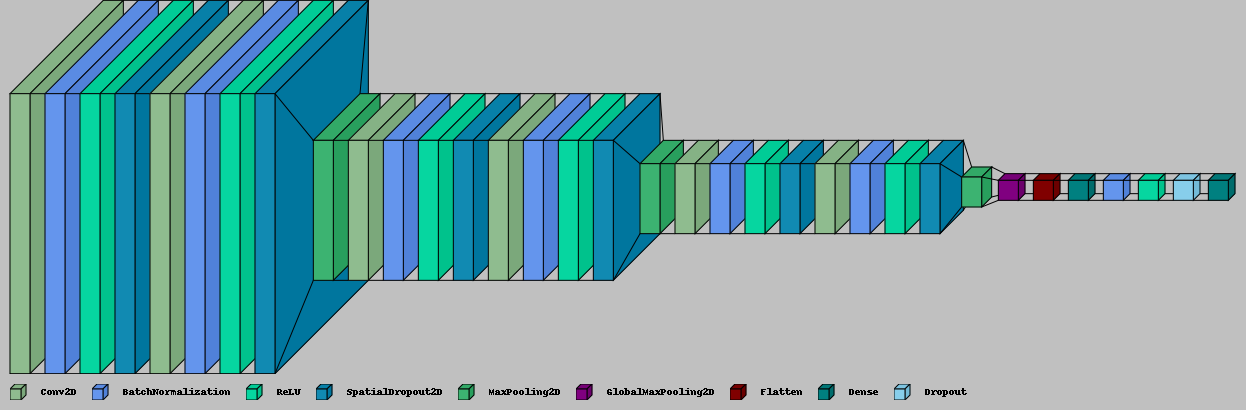

In [220]:
visualkeras.layered_view(tuned_CNN, legend=True, color_map=color_map, scale_z = 0.01, scale_xy=10, spacing=15, background_fill='silver')

In [96]:
hist_tunedCNN = train_model(tuned_CNN, x_train, y_train, x_valid, y_valid, epochs=30, batch_size=128, learning_rate=0.001, datagen=None)

Training data   : 75000
Validation data : 12500
*** Training without data augmentation. ***

Epoch 1/30
586/586 [==============================] - 39s 63ms/step - loss: 0.3753 - accuracy: 0.8772 - val_loss: 0.1647 - val_accuracy: 0.9432
Epoch 2/30
586/586 [==============================] - 36s 62ms/step - loss: 0.1780 - accuracy: 0.9411 - val_loss: 0.1730 - val_accuracy: 0.9429
Epoch 3/30
586/586 [==============================] - 36s 62ms/step - loss: 0.1491 - accuracy: 0.9499 - val_loss: 0.1388 - val_accuracy: 0.9556
Epoch 4/30
586/586 [==============================] - 37s 63ms/step - loss: 0.1331 - accuracy: 0.9548 - val_loss: 0.1089 - val_accuracy: 0.9618
Epoch 5/30
586/586 [==============================] - 36s 62ms/step - loss: 0.1225 - accuracy: 0.9584 - val_loss: 0.1089 - val_accuracy: 0.9631
Epoch 6/30
586/586 [==============================] - 36s 62ms/step - loss: 0.1147 - accuracy: 0.9613 - val_loss: 0.1031 - val_accuracy: 0.9640
Epoch 7/30
586/586 [=======================

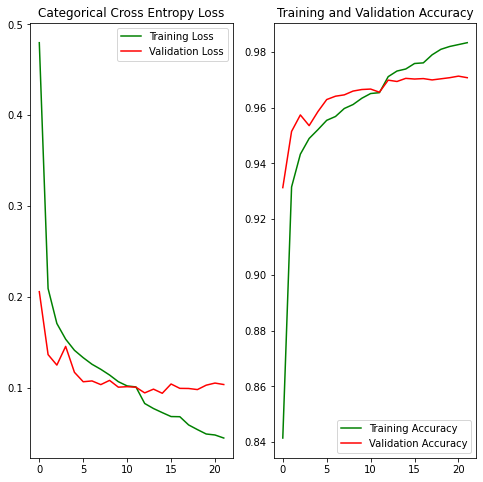

In [ ]:
display_learning(hist_tunedCNN)

In [185]:
tuned_CNN.evaluate(x_test, y_test)

391/391 [==============================] - 4s 10ms/step - loss: 0.1022 - accuracy: 0.9674


[0.10219353437423706, 0.9673600196838379]

In [186]:
# Save the model
tuned_CNN.save("tuned_cnn.h5")

Ce modèle est plus performant que les précédents. Sur la fin de l'entrainement il avait tendance à overfitter un peu mais grâce à la fonction d'early stopping que nous avons ajouté cela ne pose pas trop de problèmes.

# Data Cleaning

Maintenant que nous avons trouvé notre modèle le plus performant nous allons encore essayer d'améliorer ses performances en s'intéressant plus en détails à nos données. Nous voulions vérifier si les jeux de données étaient "propres", c'est-à-dire si les images était bien labellisées et qu'il n'y avait bien que des images des 5 classes qui nous intéressent. 

Pour cela nous avons opté pour [Clean Lab](https://github.com/cleanlab/cleanlab) qui nous paraissait être l'option la plus adaptée car facile d'utilisation et apparemment assez performante.

In [102]:
def clean_data(filename, x_train, y_train, x_valid, y_valid, x_test, y_test):
    """  
    Repère les données mal labellisées dans les datasets.
    """
    
    # Load model initially train on uncleaned data and make predictions for both training and validation sets
    model = tf.keras.models.load_model(filename)
    pred_probs_train = model.predict(x_train)
    pred_probs_valid = model.predict(x_valid)
    pred_probs_test = model.predict(x_test)

    # Make labels binary 
    labels_train = []
    for i in range(y_train.shape[0]):
        labels_train.append(np.argmax(y_train[i]))
    labels_valid = []
    for i in range(y_valid.shape[0]):
        labels_valid.append(np.argmax(y_valid[i]))
    labels_test = []
    for i in range(y_test.shape[0]):
        labels_test.append(np.argmax(y_test[i]))
    
    # Use cleanlab to find images to remove 
    idx_to_remove_train = find_label_issues(labels=labels_train,
                                            pred_probs=pred_probs_train,  # predicted probabilities from any model (ideally out-of-sample predictions)
                                            return_indices_ranked_by='self_confidence')
    idx_to_remove_valid = find_label_issues(labels=labels_valid,
                                            pred_probs=pred_probs_valid,  # predicted probabilities from any model (ideally out-of-sample predictions)
                                            return_indices_ranked_by='self_confidence')
    idx_to_remove_test = find_label_issues(labels=labels_test,
                                            pred_probs=pred_probs_test,  # predicted probabilities from any model (ideally out-of-sample predictions)
                                            return_indices_ranked_by='self_confidence')
    # Save the indices to remove in a file
    with open("indices_to_remove_train.pkl", "wb") as file:
        pickle.dump(idx_to_remove_train, file)
    with open("indices_to_remove_valid.pkl", "wb") as file:
        pickle.dump(idx_to_remove_valid, file)
    with open("indices_to_remove_test.pkl", "wb") as file:
        pickle.dump(idx_to_remove_valid, file)

    # Remove labels issues from training and validation set
    x_train_cleaned = np.delete(x_train, idx_to_remove_train, axis=0)
    y_train_cleaned = np.delete(y_train, idx_to_remove_train, axis=0)
    x_valid_cleaned = np.delete(x_valid, idx_to_remove_valid, axis=0)
    y_valid_cleaned = np.delete(y_valid, idx_to_remove_valid, axis=0)
    x_test_cleaned = np.delete(x_test, idx_to_remove_test, axis=0)
    y_test_cleaned = np.delete(y_test, idx_to_remove_test, axis=0)
    
    # Display shapes
    print("Model use for cleaning the dataset       : ", filename[:-3])
    print("Numbers of images removed while cleaning : ", len(idx_to_remove_train), len(idx_to_remove_valid), len(idx_to_remove_test))
    print("\nOriginal training data   : ",x_train.shape)
    print("Original training labels : ",y_train.shape)
    print("\nCleaned training data    : ",x_train_cleaned.shape)
    print("Cleaned training labels  : ",y_train_cleaned.shape)

    print("\nOriginal validation data   : ",x_valid.shape)
    print("Original validation labels : ",y_valid.shape)
    print("\nCleaned validation data    : ",x_valid_cleaned.shape)
    print("Cleaned validation labels  : ",y_valid_cleaned.shape)

    print("\nOriginal test data   : ",x_test.shape)
    print("Original test labels : ",y_test.shape)
    print("\nCleaned test data    : ",x_test_cleaned.shape)
    print("Cleaned test labels  : ",y_test_cleaned.shape)

    
    return x_train_cleaned, y_train_cleaned , idx_to_remove_train, x_valid_cleaned, y_valid_cleaned, idx_to_remove_valid, x_test_cleaned, y_test_cleaned, idx_to_remove_test

In [188]:
x_train_cleaned, y_train_cleaned, idx_to_remove_train, x_valid_cleaned, y_valid_cleaned, idx_to_remove_valid, x_test_cleaned, y_test_cleaned, idx_to_remove_test = clean_data(filename='tuned_cnn.h5',
                                                                                                                                                                              x_train=x_train,
                                                                                                                                                                              y_train=y_train,
                                                                                                                                                                              x_valid=x_valid,
                                                                                                                                                                              y_valid=y_valid,
                                                                                                                                                                              x_test=x_test,
                                                                                                                                                                              y_test=y_test)

Model use for cleaning the dataset       :  tuned_cnn
Numbers of images removed while cleaning :  19 35 47

Original training data   :  (75000, 28, 28, 1)
Original training labels :  (75000, 5)

Cleaned training data    :  (74981, 28, 28, 1)
Cleaned training labels  :  (74981, 5)

Original validation data   :  (12500, 28, 28, 1)
Original validation labels :  (12500, 5)

Cleaned validation data    :  (12465, 28, 28, 1)
Cleaned validation labels  :  (12465, 5)

Original test data   :  (12500, 28, 28, 1)
Original test labels :  (12500, 5)

Cleaned test data    :  (12453, 28, 28, 1)
Cleaned test labels  :  (12453, 5)


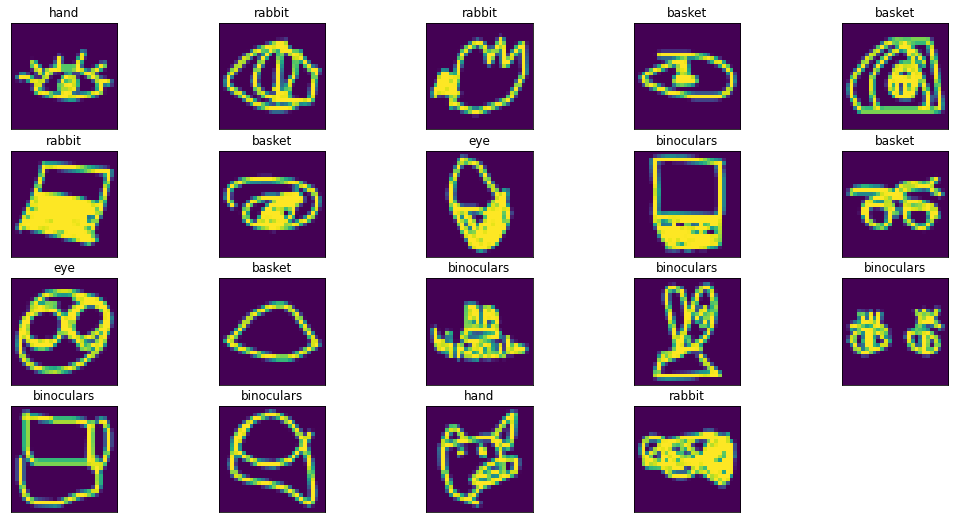

In [190]:
plot_images_bis(x=x_train, y=y_train, idx=idx_to_remove_train)

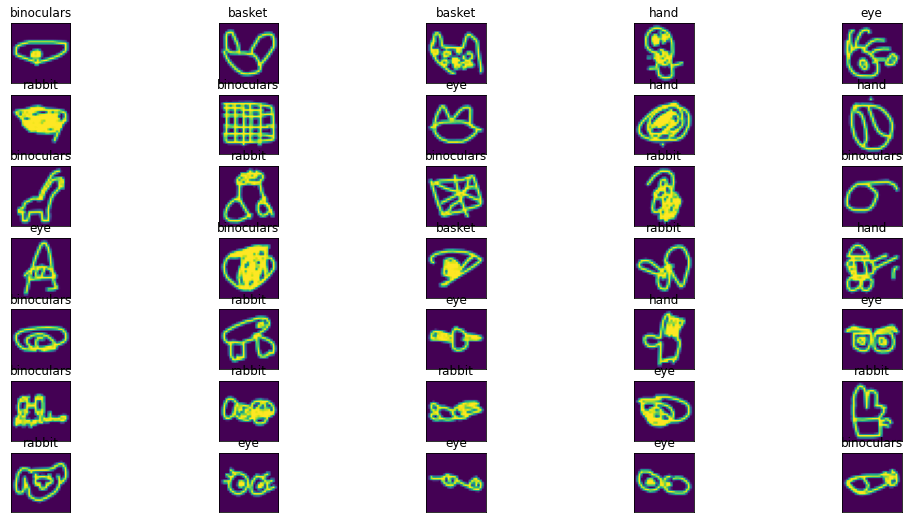

In [192]:
plot_images_bis(x=x_valid, y=y_valid, idx=idx_to_remove_valid)

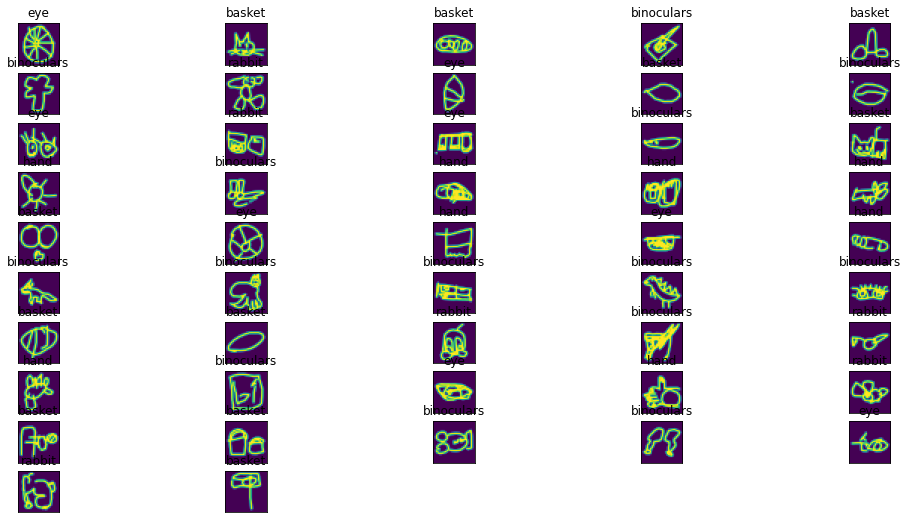

In [181]:
plot_images_bis(x=x_test, y=y_test, idx=idx_to_remove_test)

La quasi-totalité de ces images sont sont soient des images d'une des 5 classes mal annotées, soient des images de classes inconnues à notre modèle: dinausaures, roues elles nuisent à notre entraînement ainsi qu'à la precision de l'évaluation des performances de notre modèles et nous les avons donc supprimées et réentrainé le modèle sur des données (à peine) plus propres.

Sachant que l'on considère que clean lab n'a quasi fait aucune erreur (voir ci-dessus), nous les supprimons toutes (même les exceptions potentiellement vraies) de nos données sans que cela n'ait a priori d'impact.

In [194]:
tuned_CNN_cleaned = tuned_CNN_model(summary=False)
hist_tunedCNNCleaned = train_model(model=tuned_CNN_cleaned, x_train=x_train_cleaned, y_train=y_train_cleaned, x_valid=x_valid_cleaned, y_valid=y_valid_cleaned, epochs= 30, datagen=None)

Training data   : 74981
Validation data : 12465
*** Training without data augmentation. ***

Epoch 1/30
586/586 [==============================] - 37s 61ms/step - loss: 0.4575 - accuracy: 0.8528 - val_loss: 0.2971 - val_accuracy: 0.9018
Epoch 2/30
586/586 [==============================] - 36s 61ms/step - loss: 0.1897 - accuracy: 0.9371 - val_loss: 0.1219 - val_accuracy: 0.9568
Epoch 3/30
586/586 [==============================] - 36s 61ms/step - loss: 0.1556 - accuracy: 0.9484 - val_loss: 0.1170 - val_accuracy: 0.9580
Epoch 4/30
586/586 [==============================] - 36s 61ms/step - loss: 0.1398 - accuracy: 0.9536 - val_loss: 0.1304 - val_accuracy: 0.9536
Epoch 5/30
586/586 [==============================] - 36s 61ms/step - loss: 0.1305 - accuracy: 0.9559 - val_loss: 0.0963 - val_accuracy: 0.9666
Epoch 6/30
586/586 [==============================] - 36s 61ms/step - loss: 0.1226 - accuracy: 0.9589 - val_loss: 0.1009 - val_accuracy: 0.9639
Epoch 7/30
586/586 [=======================

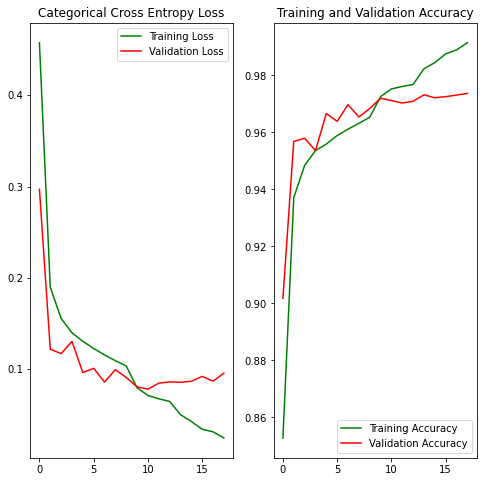

In [196]:
display_learning(hist_tunedCNNCleaned, epochs=30)

Le modèle overfit encore assez rapidement et nous pourrions augmenter le dropout sauf que nous souhaitons d'abord régulariser le modèle via la data augmentation (voir partie suivante) puis régler le dropout ensuite.

In [198]:
tuned_CNN_cleaned.evaluate(x_test_cleaned, y_test_cleaned)

390/390 [==============================] - 4s 10ms/step - loss: 0.0795 - accuracy: 0.9709


[0.07954667508602142, 0.9709306955337524]

In [199]:
tuned_CNN_cleaned.evaluate(x_test, y_test)

391/391 [==============================] - 4s 11ms/step - loss: 0.1059 - accuracy: 0.9674


[0.10587531328201294, 0.9674400091171265]

On remarque qu'avoir x_test et y_test avec de nombreuses erreurs de labels trompe l'évaluation des performances. Le seconde évaluation est une meilleure aproximation de nos performances sur le set de test. Nous dépassons les 97% de précison pour la première fois ! 

In [120]:
# tuned_CNN_cleaned.evaluate(x_test_cleaned, y_test_cleaned)

On peut voir qu'en fonction du datasets sur lequel on évalue le modèle, les performances sont sensiblement différentes. Le nettoyage de données nous a aussi permis d'avoir un estimation plus précise de la performance réelle de notre modèle.

# Data Augmentation

Comme nous l'avons vu en cours la Data Augmentation est une méthode classique qui permet d'augmente la taille du jeu de donnée d'entrainement tout evidemment en y ajoutant de la variété en effectuant des opérations sur les images, ici: 
* des rotations avec un angle maximum de 30 degrès,
* des zooms avec de -20% à 20% de la taille d'origine,
* des décalage sur horizontalement et verticalement

Cette méthode, couplée au netttoyage précédent, permet de créer un grand nobre d'images de qualités et ainsi de mieux entrainer notre modèle.

In [200]:
tuned_CNN_cleaned_augmented = tuned_CNN_model(summary=False)

datagen = ImageDataGenerator(rotation_range=30,  
                             zoom_range = 0.2,  
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             fill_mode='nearest')

hist_tunedCNNCleanedAugmented = train_model(model=tuned_CNN_cleaned_augmented, x_train=x_train_cleaned, y_train=y_train_cleaned, x_valid=x_valid_cleaned, y_valid=y_valid_cleaned, epochs= 50, datagen=datagen)

Training data   : 74981
Validation data : 12465
*** Training with data augmentation. ***

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


586/586 [==============================] - 43s 70ms/step - loss: 0.7472 - accuracy: 0.7427 - val_loss: 0.2200 - val_accuracy: 0.9309
Epoch 2/50
586/586 [==============================] - 40s 68ms/step - loss: 0.2800 - accuracy: 0.9082 - val_loss: 0.1692 - val_accuracy: 0.9451
Epoch 3/50
586/586 [==============================] - 39s 67ms/step - loss: 0.2319 - accuracy: 0.9227 - val_loss: 0.1294 - val_accuracy: 0.9558
Epoch 4/50
586/586 [==============================] - 42s 71ms/step - loss: 0.2137 - accuracy: 0.9298 - val_loss: 0.1149 - val_accuracy: 0.9590
Epoch 5/50
586/586 [==============================] - 41s 70ms/step - loss: 0.1969 - accuracy: 0.9352 - val_loss: 0.1168 - val_accuracy: 0.9597
Epoch 6/50
586/586 [==============================] - 40s 68ms/step - loss: 0.1875 - accuracy: 0.9382 - val_loss: 0.1153 - val_accuracy: 0.9584

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/50
586/586 [==============================] - 40s 67ms/step

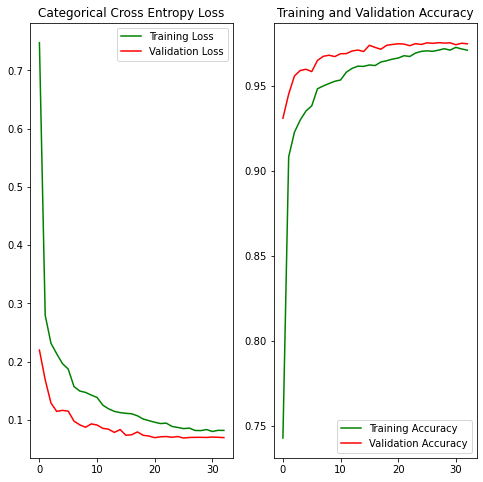

In [201]:
display_learning(hist_tunedCNNCleanedAugmented, epochs=38)

In [202]:
tuned_CNN_cleaned_augmented.evaluate(x=x_test, y=y_test)

391/391 [==============================] - 4s 10ms/step - loss: 0.0925 - accuracy: 0.9732


[0.09250151365995407, 0.9732000231742859]

In [203]:
tuned_CNN_cleaned_augmented.evaluate(x=x_test_cleaned, y=y_test_cleaned)

390/390 [==============================] - 4s 10ms/step - loss: 0.0722 - accuracy: 0.9762


[0.07220765203237534, 0.9762306213378906]

La data augmentation a été très efficace et nous a permis de supprimer l'overfitting et d'améliorer notre score sur le test set.

In [204]:
tuned_CNN_cleaned_augmented.save('final_model.h5')

## Matrice de confusion

In [205]:
model = load_model('final_model.h5')

In [131]:
def matrice_confusion(model, x_test, y_test, true_positives=True):
    """
    What it does it does it well.
    """
    # Make predictions
    predictions = model.predict(x_test)

    # Construct array of classes predictions
    y_pred_cp = []
    y_test_cp = []
    for i in range(predictions.shape[0]):
        y_pred_cp.append(np.argmax(predictions[i]))
    for i in range(y_test.shape[0]):
        y_test_cp.append(np.argmax(y_test[i]))

    y_pred_cp = np.array(y_pred_cp)
    y_test_cp = np.array(y_test_cp)
    # Compute confusion matrix with help of scikit-learn function confusion_matric()
    mat = confusion_matrix(y_test_cp, y_pred_cp)

    # We can anneal true positives which hide errors when we already have a high accuracy for each class
    if not(true_positives):
        title ="Matrice de confusion SANS prise en compte des true positives"
        for d in range(mat.shape[0]):
            mat[d][d] = 0
    else: title="Matrice de confusion AVEC prise en compte des true positives" 

    # Display the confusion matrix with heatmap 
    plt.figure(figsize=(10, 8))
    sns.heatmap(data=mat, annot=True, fmt=".0f", cmap="crest")
    plt.xlabel('Predictions')
    plt.ylabel('Classes')
    plt.title(title)
    plt.plot()

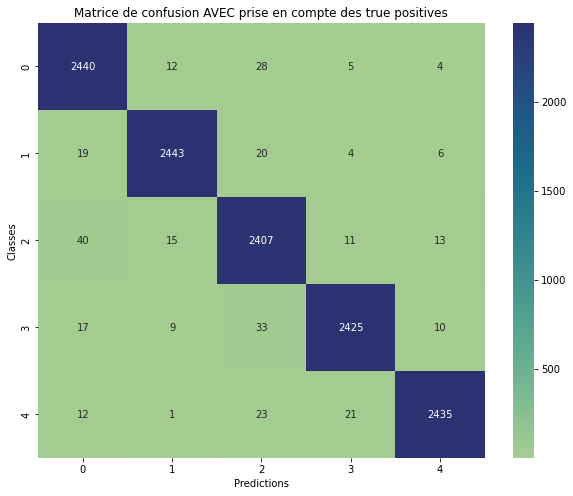

In [132]:
matrice_confusion(model=model, x_test=x_test_cleaned, y_test=y_test_cleaned, true_positives=True)

Cette matrice de conclusion ne permet pas de visualiser correctement les classes avec le plus d'erreus car la majorité des prédictions sont justes. Afin de régle ce problème nous n'allons plus prendre en compte les valeurs de la diagonales (vrais positifs de chaque classe).

390/390 [==============================] - 4s 11ms/step


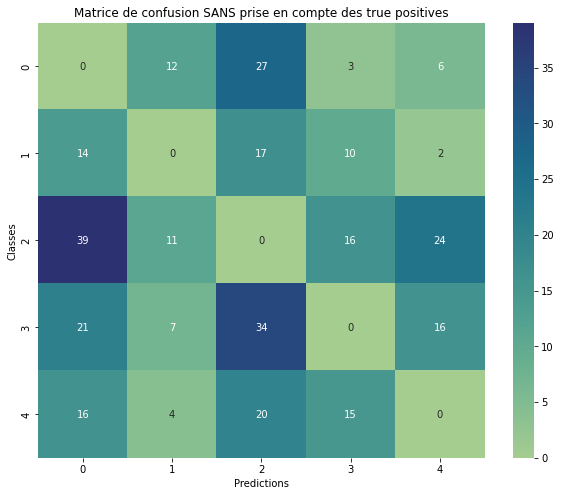

In [ ]:
matrice_confusion(model=model, x_test=x_test_cleaned, y_test=y_test_cleaned, true_positives=False)

Ici on voit clairement qu'une classe pose plus de problèmes ques les autres et il s'agit de la classe 2 (les lunettes). Il s'agit peut être d'une piste à creuser pour continuer l'étude du problème.

Nous obtenons ainsi aprés entrainement de notre modèle final sur note jeu de données un score de 97, 

Ces scores nous confirme que notre modèle est approprié pour effectuer la classification demandée.

# Pistes d'améliorations




*   Approfondir le nettoyage des données
*   Tester des architectures différentes du CNN (LSTM, CNN + RNN...)
*   Faire des hyperparamètres search plus approndies selon les ressources disponibles 
*   Chercher à améliorer les performances sur les lunettes (classes 2) qui semble être celle qui pose le plus de problème à notre modèle.


